In [153]:
cd /home/felipe/Escritorio/Codigos_physical_conditions/

/home/felipe/Escritorio/Codigos_physical_conditions


In [154]:
image12CO = '/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/smooth_image_12co32_o500_i159.00_phi90.00_PA-24.00'
image13CO = '/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/smooth_image_13co32_o500_i159.00_phi90.00_PA-24.00'
imageC18O = '/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/smooth_image_c18o32_o500_i159.00_phi90.00_PA-24.00'

imageC18O_2 = '/home/felipe/Escritorio/nuevos_cubos/Faceon/image_c18o32_dust_o500_i180.00_phi90.00_PA-24.00'
image13CO_2 = '/home/felipe/Escritorio/nuevos_cubos/Faceon/image_13co32_dust_o500_i180.00_phi90.00_PA-24.00'
image12CO_2 = '/home/felipe/Escritorio/nuevos_cubos/Faceon/image_12co32_dust_o500_i180.00_phi90.00_PA-24.00'

imageC18O_nodust = '/home/felipe/Escritorio/nuevos_cubos/Faceon/no_dust/image_c18o32_nodust_o500_i180.00_phi90.00_PA-24.00'
image12CO_nodust = '/home/felipe/Escritorio/nuevos_cubos/Faceon/no_dust/image_12co32_nodust_o500_i180.00_phi90.00_PA-24.00'
image13CO_nodust = '/home/felipe/Escritorio/nuevos_cubos/Faceon/no_dust/image_13co32_nodust_o500_i180.00_phi90.00_PA-24.00' 


In [4]:

import collision_cross_section	as ccs				# auxiliar quantities
import help_functions as hf					# finding maximum
from constants import *

import numpy as np
import scipy as sp
from scipy.integrate import quad
import pyfits as pf
import matplotlib.pyplot as plt
import scipy.ndimage.measurements as meas
import glob
import os
import math
from iminuit import Minuit
import sys
from astropy.convolution import Gaussian2DKernel, convolve_fft


h=6.62606957*10**(-34)
c=2.99792458*10**8
k=1.3806488*10**(-23)

#d12 = -38772.7057800293
#nu12i = 230538019386.3495 - d12*29
#nu12f = 230538019386.3495 + d12*30

#d13 = -37067.44424438477
#nu13i = 220398702661.8233 - d13*59
#nu13f = 220398702661.8233 + d13*60

#d18 = -36926.43966674805
#nu18i = 219560372563.2249 - d18*59.
#nu18f = 219560372563.2249 + d18*60.


d12 = -58157.20745849609
nu12i = 345796018978.6035 - d12*59
nu12f = 345796018978.6035 + d12*60

d13 = -55599.46649169922
nu13i = 330587993021.5317 - d13*59
nu13f = 330587993021.5317 + d13*60

d18 = -55387.990234375
nu18i = 329330580193.9937 - d18*59.
nu18f = 329330580193.9937 + d18*60.


In [5]:
def datafits(namefile):
    """
    Open a FITS image and return datacube and header, namefile without '.fits'
    """
    datacube = pf.open(namefile + '.fits')[0].data
    hdr = pf.open(namefile + '.fits')[0].header
    return datacube, hdr


def bbody(t,nu):
    """
    Blackbody flux for a given temperature and frequency W/(m^2*Hz*sr) (mks system)
    """
    return (1.4745e-50)*nu**3.0/(sp.exp(4.79922e-11*nu/t)-1.0)


def phi(t,nu,nu0,vturb,angle, m):
    """
    vturb m*s^-1
    """
    pa = (-20+90+angle)*math.pi/180.0  #-20 is the PA from east of north, and 90 to get the semi-minor axis
    Q = 1
    shear = (Q*math.sin(incli)**2)*(math.tan(incli)**2)*math.sin(2*pa)**2
    deltav = (nu0/c)*math.sqrt(k*t/m + vturb**2 )*(1+shear)**(0.5)
    phi0 = deltav*math.sqrt(2*math.pi)
    gauss=sp.exp(-((nu-nu0)**2.0)/(2*(deltav**2.0)))
    aux = gauss/phi0
    return aux/sp.sum(aux)


def tau(t,nu,nu0,nco,vturb,angle,iso=12):
    """
    Optical depth with turbulent velocity and thermal velocity
    sigma is cross area cm^2
    """
    sigma = ccs.cross_section("13CO")
    m = ccs.molecular_mass("13CO")
    if iso==12:
        sigma = ccs.cross_section("12CO")
        m = ccs.molecular_mass("12CO")
    elif iso==13:
        sigma = ccs.cross_section("13CO")
        m = ccs.molecular_mass("13CO")
    elif iso==18:
        sigma = ccs.cross_section("C18O")
        m = ccs.molecular_mass("C18O")
#    sigma = sigma/(m*10**9)
    return nco*sigma*phi(t,nu,nu0,vturb,angle, m)/math.cos(incli)

def intensity(nu, T, nu0, alpha, nco, vturb, angle, i0, hdr, iso=12):
    """
    Solution to radiative transfer equation
    """
    if iso==13:
        nco/= 70.
    elif iso==18:
        nco/=500.        
    pix_deg = abs(hdr['CDELT1'])
    pix_rad = pix_deg*sp.pi/180.
    bminaxis =  pix_deg  #arcsec
    bmajaxis = pix_deg  #arcsec,
    scaling = (sp.pi/4.)*1e26*pix_rad**2 
    blackbody = bbody(T,nu)*(1.0-sp.exp(-tau(T,nu,nu0,nco,vturb,angle, iso)))*3*scaling
    cont = i0*sp.exp(-tau(T,nu,nu0,nco,vturb,angle, iso))*(nu/nu0)**alpha
    #    cont = i0*sp.exp(-tau(T,nu,nu0,nco,vturb,angle, iso))*(nu/nu0)**alpha
    return  blackbody + cont


def iintensity(nu, T, nu0, alpha, nco, vturb, angle, i0, hdr, iso=12):
    dnu = (abs(nu[1] - nu[0]))/2.
    I_nu = sp.zeros(len(nu))
    for i in range(len(nu)):
         I_nu[i]= quad(intensity, nu[i]-dnu, nu[i]+dnu, args=(T, nu0 ,alpha, nco, vturb, angle, i0, hdr, iso))[0]
    return I_nu       

def intensity_err(nu, nu0, T, alpha, i0, nco, vturb, angle, datos, hdr, iso=12):
    """
    Chi squared of data with fit of spectral line, both normalized.
    """
    model = intensity(nu, T, nu0, alpha, nco, vturb, angle, i0, hdr, iso)
    aux = (datos-model)**2
    chi = sp.sum(aux)
    return chi


def flux_int(T, alpha, i0, nco, vturb, angle, datos, hdr12, hdr13, hdr18):
    """
    Chi^2 obtained integrating function from radiative transfer
    in the spectral window of each isotopologue divided by molecular fractions.
    """
    nu013 = 220398702661.8233
    nu012 = 230538019386.3495
    nu018 = 219560372563.2249
    integral12 = quad(intensity, nu12i, nu12f, args=(T, nu012 ,alpha, nco, vturb, angle, i0, hdr12, 12))
    integral13 = quad(intensity, nu13i, nu13f, args=(T, nu013 ,alpha, nco/70., vturb, angle, i0, hdr13, 13))
    integral18 = quad(intensity, nu18i, nu18f, args=(T, nu018 ,alpha, nco/500., vturb, angle, i0, hdr18, 18))
    chi2 = sp.sum((datos[0]-integral12[0]*nu012/c)**2) + sp.sum((datos[1]-integral13[0]*nu013/c)**2) + ((datos[2]-integral18[0]*nu018/c)**2)
    return chi2


In [6]:
incli=0

In [7]:
cubo, head = datafits(imageC18O_2)
cubomax = cubo.max()
stderr = sp.std(cubo)
alpha = 2.3
angle = 24.*sp.pi/180.
i0=0.
Temperature = sp.zeros((256,256))
Denscol = sp.zeros((256,256))
Turbvel = sp.zeros((256,256))
errpars = sp.zeros((256,256,3))
errmodel = sp.zeros((256,256))
model = sp.zeros((256,256,120))
model2 = sp.zeros((256,256,120))
mom1 = sp.zeros((256,256))

In [158]:
25/130.

0.19230769230769232

In [ ]:
iso = 18
r=80
if iso==12:
    nu0 = 230538019386.3495
    nu = sp.linspace(nu12i, nu12f, 120)
    f=1.
    nues = sp.linspace(nu12i, nu12f, 200)
    ncoscale=5e20
elif iso==13:
    ncoscale = 5e17
    nu0 = 220398702661.8233
    nu= sp.linspace(nu13i, nu13f, 120)
    nues = sp.linspace(nu13i, nu13f, 200)
    f=1e-2
    dnu = d13
else:
    ncoscale = 3e17
    nu0 = 219560372563.2249
    nu = sp.linspace(nu18i, nu18f, 120)
    nues = sp.linspace(nu18i, nu18f, 200)
    f=1.7e-7/1e-4
    dnu = d18
#Change to mks and m1 from velocity to frequency

cubomax = cubo.max()

image1 ='/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/nosmooth_Simslines_18_v_turb'
datamdel = pf.open(image1+'.fits')[0].data
datamdel[datamdel==0]=None


i,j = 110,110
while True:
    if (i-128)**2 + (j-128)**2>r**2:
        break
        
#plt.figure(1)
#plt.clf()
    plt.imshow(datamdel, cmap='inferno', origin='lower') 
    plt.grid(False)
    l = plt.ginput(1)
    i = int(l[0][0])
    j= int(l[0][1])
    print i,j
    
    data = cubo[40:80,i,j]

    datamax = data.max()
    datamin = data.min()
    data1 = data -data.min()
    centroid = (nu*(cubo[:,i,j]-datamin)).sum()/(cubo[:,i,j]-datamin).sum()
    i0_model = data.min()
    if i0_model==0:
        i0_model=1e-8
    s = data.sum()
#    data/= data.sum()

    r_ij = sp.sqrt((i-128)**2 +(j-128)**2)

    if r_ij>20 and r_ij<50:
        tscale = 130.
        i_0 = 0.1
        t0 = 0.18#*(r_ij*280/128.)**(-1/1.5)
        tlim =(0.05,1.)
        ncoscale *= 0.1
    elif r_ij>=50.:
        tscale = 80.
        i_0 = 0.1
        t0 = 350*(r_ij*280./128.)**(-1/1.5)/80.
        tlim =(0.05,1.)
    else:
        i_0 = 0.1
        tscale=200.
        t0 = 0.4
        tlim = (0.05,1.)
# iminuit least squares fit

#f = lambda Temp,vturb,NcolCO: intensity_err(nu, centroid, Temp*tscale, alpha, 0., ncoscale*NcolCO,
#                                            600.*vturb, angle, data, head, iso)
#m = Minuit(f, Temp=t0, vturb=0.04, NcolCO=0.00001, errordef=stderr/datamax,
#            error_Temp=.005, error_NcolCO=0.0000005, error_vturb=0.005,
#            limit_Temp=tlim, limit_vturb=(0.002, 1), limit_NcolCO=(0.0000001, 1))

    f = lambda Temp,vturb,NcolCO,i0, nu0: intensity_err(nu[40:80], nu0, Temp*tscale, alpha, i0, ncoscale*NcolCO,
                                                    700.*vturb, angle, data, head, iso)
    m = Minuit(f, Temp=t0, vturb=0.04, NcolCO=0.00001,i0=i0_model, nu0=centroid, errordef=stderr/datamax,
                error_Temp=.005, error_NcolCO=0.0000005, error_vturb=0.005, error_i0=i0_model/100., error_nu0=abs(dnu)/5.,
                limit_Temp=tlim, limit_vturb=(0.002, 1), limit_NcolCO=(0.0000001, 1), limit_i0=(0.8*i0_model,1.5*i0_model),
              limit_nu0=(centroid-1.2*abs(dnu), centroid+1.2*abs(dnu)))
    m.migrad(1e9)

#errmod = f(m.values['Temp'], m.values['vturb'], m.values['NcolCO'])
#fit = [m.values['Temp']*tscale, m.values['vturb']*600., ncoscale*m.values['NcolCO']]


    errmod = f(m.values['Temp'], m.values['vturb'], m.values['NcolCO'], m.values['i0'], m.values['nu0'])
    fit = [m.values['Temp']*tscale, m.values['vturb']*700., ncoscale*m.values['NcolCO'], m.values['i0'], m.values['nu0']];
    error = [m.errors['Temp']*tscale, m.errors['vturb']*700., ncoscale*m.errors['NcolCO']];

    Temperature[i,j] = fit[0]
    Denscol[i,j] = fit[2]
    Turbvel[i,j] = fit[1]
    errpars[i,j] = error
    errmodel[i,j] = errmod

    model[i,j] = intensity(nu, fit[0], fit[4], alpha, fit[2], fit[1], angle, fit[3], head, iso)
    model2[i,j] = intensity(nu, 0.75*fit[0], fit[4], alpha, fit[2], 0.2*fit[1] , angle, fit[3], head, iso)    


    plt.style.use('seaborn-paper')
    velocity = sp.linspace(-3,3,120.)
    plt.figure(2)
    plt.clf()
    plt.grid(False)
    plt.xlabel('$km/s$', fontsize=14)
    plt.ylabel('$Jy/Beam$', fontsize=14)
    xs = sp.linspace(0,120,7)
    plt.plot(velocity[40:80], data, 'r.', label='simulation $C^{18}O$')
    plt.plot(velocity[40:80], model[i,j,40:80],'k', label='model') 
#    plt.plot(velocity[45:75], model2[i,j,45:75],'g', label='model2')    
    plt.legend(fontsize=12, loc=2)
    plt.tight_layout()
    print errmod
    print intensity_err(nu[40:80], fit[4], fit[0], alpha, fit[3], fit[2], fit[1], angle, data, head, iso)
    print intensity_err(nu[40:80], fit[4], fit[0]*1.1, alpha, fit[3], fit[2], fit[1], angle, data, head, iso)
    print sp.sum((data-model[i,j,40:80])**2),sp.sum((data-model2[i,j,40:80])**2),r_ij
    print fit
    plt.show()

import matplotlib as mpl
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

In [9]:
data[45:75].shape

(15,)

/home/felipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: InitialParamWarning: errordef is not given. Default to 1.


FCN = 8.62656649855e-09 
 TOTAL NCALL = 103 
 NCALLS = 103 
 
 
 EDM = 4.87209125429e-07 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 False 
 False 
 True 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,amp,0.000812129,0.000208092,0,0,0.000614413293079,0.000921619939618,
2,mu,-0.000254453,0.204687,0,0,-0.15002691873,0.14997308127,
3,disp,0.144347,1.91661,0,0,0.02,2.0,
4,i0,1.00527e-05,9.54118e-06,0,0,0.0,1.20632328617e-05,


8.62656649855e-09
[0.0008121291337210013, -0.00025445294559309217, 0.1443467968322463, 1.0052694066968932e-05]


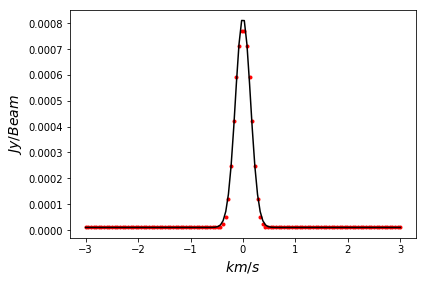

In [9]:
from scipy.stats import norm
%matplotlib inline

def gaussian(x,y,amp,mu,sigma, i0):
    gauss = amp*sp.exp(-(x-mu)**2/(2*sigma**2)) + i0
    chi2 = sp.sum((gauss-y)**2)
    return chi2

r=80.
cubomax = cubo.max()
vels = sp.linspace(-3 ,3, 120)

image1 ='/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/nosmooth_Simslines_18_v_turb'
datamdel = pf.open(image1+'.fits')[0].data
datamdel[datamdel==0]=None

i,j = 110,110


#plt.imshow(datamdel, cmap='inferno', origin='lower') 
#plt.grid(False)
#l = plt.ginput(1)
#i = int(l[0][0])
#j= int(l[0][1])
#print i,j
    
data = cubo[:,i,j]

datamax = data.max()
datamin = data.min()
data1 = data -data.min()
centroid = (vels*data1).sum()/data1.sum()
std = sp.dot((vels-centroid)**2,data)/data1.sum()

r_ij = sp.sqrt((i-128)**2 +(j-128)**2)

f = lambda amp, mu, disp, i0: gaussian(vels[45:75], data[45:75], amp, mu, disp, i0)
m = Minuit(f, amp=datamax, mu=centroid, disp=std, i0=datamin,
            error_amp=datamax*0.01, error_disp=0.005, error_mu=0.01, error_i0=datamin*0.01,
            limit_amp=(datamax*0.8,datamax*1.2), limit_disp=(0.02, 2.), limit_mu=(centroid-0.15, centroid+0.15),
            limit_i0=(0,1.2*datamin))
m.migrad(1e9)

errmod = f(m.values['amp'], m.values['mu'], m.values['disp'], m.values['i0'])
fit = [m.values['amp'], m.values['mu'], m.values['disp'], m.values['i0']]
error = [m.errors['amp'], m.errors['mu'], m.errors['disp'], m.errors['i0']];

model = fit[0]*sp.exp(-(vels-fit[1])**2/(2*fit[2]**2)) + fit[3]

plt.figure(2)
plt.clf()
plt.grid(False)
plt.xlabel('$km/s$', fontsize=14)
plt.ylabel('$Jy/Beam$', fontsize=14)
xs = sp.linspace(0,120,7)
plt.plot(vels, data, 'r.', label='simulation $C^{18}O$')
plt.plot(vels, model,'k', label='model') 
#    plt.fill_between(vels, model-e, model+e, facecolor='gray', alpha=0.5)
plt.tight_layout()
print errmod
print fit
    

In [49]:
import pyfits as pf
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.colors import LogNorm


tag1='Temp'
tag2='v_turb'
tag3='NCO'
image1 = '/home/felipe/Escritorio/nuevos_cubos/smooth_Simslines_18_'+tag2
image2 = '/home/felipe/Escritorio/nuevos_cubos/no_smooth_Simslines_18_model'
#image1 ='/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/no_smooth_Simslines_18_' + tag2
#image2 = '/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/no_smooth_Simslines_18_model'
modeldata = pf.open(image2+'.fits')[0].data
modeldata = sp.sum(modeldata,axis=0)
datamdel = pf.open(image1+'.fits')[0].data
modeldata[datamdel==0]=None
datamdel[datamdel<=0.001]=None

cmap1 = 'hot'
cmap2 = 'plasma'
cmap3 = 'inferno'
cmap4 = 'magma'

imagesmooth1 ='/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/smooth_Simslines_13_v_turb'
imagesmooth2 = '/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/Simslines_13_model'
smodeldata = pf.open(imagesmooth2+'.fits')[0].data
smodeldata = sp.sum(smodeldata,axis=0)
sdatamdel = pf.open(imagesmooth1+'.fits')[0].data
smodeldata[sdatamdel==0]=None
sdatamdel[sdatamdel==0]=None

plt.style.use('seaborn-white')
fig = plt.figure()
fig.clf()
#plt.imshow(datamdel, cmap='magma', origin='lower', norm=LogNorm(1e12,1e18))

plt.imshow(datamdel, cmap='inferno', origin='lower')
plt.clim([0,350])
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
plt.grid(False)
cb1 = plt.colorbar(ax=ax)
cb1.ax.tick_params(labelsize=16)
plt.contour(smodeldata, sp.array([0.0022]), linewidth=10, cmap='inferno', origin='lower')

plt.show()

In [50]:
Beam = 0.25
resol = abs(head['CDELT1'])*3600
stdev = Beam / (2 * sp.sqrt (2 * sp.log(2)))
stdev /= resol
x_size = int(8*stdev + 1.)
beam = Gaussian2DKernel (stddev = stdev, x_size = x_size, y_size = x_size,
                        model ='integrate')
smooth =  np.zeros((256, 256))
smooth += convolve_fft(datamdel, beam)
smooth[smooth<1] = None
plt.imshow(smooth[40:216,40:216], cmap='seismic', origin='lower')
#plt.clim([20,230])
#plt.imshow(datamdel, cmap='magma', origin='lower', norm=LogNorm(1e12,1e18))
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
plt.grid(False)
cb1 = plt.colorbar(ax=ax, pad=0.01)
cb1.ax.tick_params(labelsize=16)
plt.contour(smodeldata[40:216,40:216], sp.array([0.0022]), linewidth=10, cmap='inferno', origin='lower')

plt.show()

In [43]:
plt.figure(2)

cont = '/home/felipe/Escritorio/nuevos_cubos/HD142527cont.fits'
imatag = '/home/felipe/Escritorio/ID/HD142527/Physical_condition_32/lines_18_'+tag2
ima = '/home/felipe/Escritorio/ID/HD142527/Physical_condition_32/lines_13_model'

contsh = pf.open(cont)[0].data
contsh = contsh[0,0,:,:]
data18tag = pf.open(imatag+'.fits')[0].data
data18 = pf.open(ima+'.fits')[0].data
data18=sp.sum(data18,axis=0)

data18tag[data18tag==0]=None
data18[data18==0]=None


levels=sp.array([0.005, 0.012, 0.019])
plt.contour(contsh[256-60:256+60, 256-60:256+60], levels, lw=10, cmap='viridis', origin='lower')
plt.imshow(data18tag[256-60:256+60,256-60:256+60], cmap='hot_r', origin='lower')#,norm=LogNorm(5e11,1e18))
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
cb1 = plt.colorbar(ax=ax)
cb1.ax.tick_params(labelsize=16)
plt.clim([100,350])
plt.show()

In [87]:
plt.figure(3)

cont = '/home/felipe/Escritorio/nuevos_cubos/HD142527cont.fits'
imatag = '/home/felipe/Escritorio/ID/HD142527/HD142527_12CO21.clean_MOM2'
#imatag = '/home/felipe/Escritorio/ID/HD142527/HD142527_13CO_contrest_MOM2'
ima = '/home/felipe/Escritorio/ID/HD142527/Physical_condition_32/lines_13_model'

contsh = pf.open(cont)[0].data
contsh = contsh[0,0,:,:]
data18tag = pf.open(imatag+'.fits')[0].data
data18 = pf.open(ima+'.fits')[0].data
data18=sp.sum(data18,axis=0)

data18tag[data18tag==0]=None
data18[data18==0]=None
data18tag[data18tag<0.2] = None

levels=sp.array([0.005, 0.012, 0.019])
plt.contour(contsh[256-60:256+60, 256-60:256+60], levels, lw=10, cmap='viridis', origin='lower')
plt.imshow(1000*data18tag[256-60:256+60,256-60:256+60], cmap='magma', origin='lower')#,norm=LogNorm(5e11,1e18))
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=20)
cb1 = plt.colorbar(ax=ax)
cb1.ax.tick_params(labelsize=16)
plt.clim([100,1500])
plt.show()

In [51]:
image1 ='/home/felipe/Escritorio/ID/HD142527/Simulations_CO3-2/no_smooth_Simslines_13_' + tag1
datamdel = pf.open(image1+'.fits')[0].data
datamdel[datamdel==0]=None

def line(theta):
    pairs = sp.zeros((35,2))
    for i in range(35):
        r = 3.*(i+1)
        pairs[i,0] = int(r*sp.cos(theta)) + 128
        pairs[i,1] = int(r*sp.sin(theta)) + 128
    return pairs

def angles(r):
    pairs = sp.zeros((int(3*r),2))
    thetas = sp.linspace(0, 2*sp.pi, int(3*r))
    for i in range(int(3*r)):
        pairs[i] = int(r*sp.cos(thetas[i]))+128, int(r*sp.sin(thetas[i]))+128
    return pairs, thetas    
        
        
r= sp.arange(3,108,3)        
x0,y0=128,128


In [52]:
while True:  
    if (x0-128)**2 + (y0-128)**2>120**2:
        break
    plt.clf()
    plt.imshow(smooth, cmap='inferno', origin='lower')  
    l = plt.ginput(1)
    x0 = l[0][0]
    y0 = l[0][1]
    if (x0-128)**2 + (y0-128)**2>120**2:
        pass
    r0 = sp.sqrt((x0-128)**2 +(y0-128)**2) 
#    x = sp.array([int(xy[0]) for xy in l])
#    y = sp.array([int(xy[1]) for xy in l]) 
#    z = sp.array([datamdel[x[i],y[i]] for i in range(len(l))])
    theta = sp.arctan((y0-128.)/(x0-128.))
#    xy = line(theta)
    xy, phis = angles(r0)
    z = sp.array([datamdel[x[0],x[1]] for x in xy])
    phis *= 180./sp.pi
    z = sp.nan_to_num(z)
    plt.figure(2)
    plt.plot(phis,z,'*')
    plt.xlim([0,360])
    plt.show()
    if r0<10:
        break

/home/felipe/anaconda2/lib/python2.7/site-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)
/home/felipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [20]:
r = sp.arange(5,80)
M = sp.zeros(80-5)


def angles(r):
    pairs = sp.zeros((int(3*r),2))
    thetas = sp.linspace(0, 2*sp.pi, int(3*r))
    for i in range(int(3*r)):
        pairs[i] = int(r*sp.cos(thetas[i]))+256, int(r*sp.sin(thetas[i]))+256
    return pairs, thetas 


for i in range(5,80):
    xy, phis = angles(i)
    z = sp.array([data18tag[x[0],x[1]] for x in xy])
    M[i-5] = sp.mean(z)
M = sp.nan_to_num(M)
plt.plot(r,M)
plt.xlim([20,80])
plt.show()
    

/home/felipe/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [45]:
xticks = sp.linspace(-2,2,5)
velocities = sp.linspace(-3,3,120)
xticks = [str(x) for x in xticks]
xs = sp.linspace(-2,2,5)

import matplotlib as mpl

plt.style.use('seaborn-paper')

mpl.rcParams['xtick.labelsize'] = 16
mpl.rcParams['ytick.labelsize'] = 16


nodust_12 = pf.open(image12CO_nodust+'.fits')[0].data
withdust_12 = pf.open(image12CO_2+'.fits')[0].data

nodust_13 = pf.open(image13CO_nodust+'.fits')[0].data
withdust_13 = pf.open(image13CO_2+'.fits')[0].data

nodust_18 = pf.open(imageC18O_nodust+'.fits')[0].data
withdust_18 = pf.open(imageC18O_2+'.fits')[0].data

j, i= 179,100
rests_18 = withdust_18 - nodust_18
rest18_ij = rests_18[:,j,i]

rests_12 = withdust_12 - nodust_12
rest12_ij = rests_12[:,j,i]

rests_13 = withdust_13 - nodust_13
rest13_ij = rests_13[:,j,i]

#plt.plot(restij)
plt.plot(velocities,1000*rest18_ij,'b-.',label='$C^{18}O$')
plt.plot(velocities,1000*rest13_ij,'g--',label='$^{13}CO$')
plt.plot(velocities,1000*rest12_ij,'r-',label='$^{12}CO$')
plt.xlim([-2,2])
plt.xticks(xs,xticks)
plt.xlabel('$km/s$', fontsize=18)
plt.ylabel('$mJy/Beam$', fontsize=18)
print('\tEmission C18O: '+str(rest18_ij.min()/sp.median(rest18_ij)))
print('\tEmission 13CO: '+str(rest13_ij.min()/sp.median(rest13_ij)))
print('\tEmission 12CO: '+str(rest12_ij.min()/sp.median(rest12_ij)))
plt.legend(fontsize=16, loc=4)
plt.ylim([-0.0001,1300*rest12_ij.max()])
plt.tight_layout()

plt.show()

	Emission C18O: 0.0992188
	Emission 13CO: 0.0159211
	Emission 12CO: 0.000168539


In [34]:
velocities.shape

(120,)